In [ ]:
import glob
import torch
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms as T
from torchmetrics.functional import dice
import segmentation_models_pytorch as smp
from torch.utils.data import Dataset, DataLoader

In [ ]:
# Hyperparamters
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 1e-3

In [ ]:
imagenet_mean = np.mean(np.array([0.485, 0.456, 0.406]))
imagenet_std = np.mean(np.array([0.229, 0.224, 0.225]))

def get_transforms():
    return T.Compose([
        T.ToTensor(),
        T.Normalize(
            [imagenet_mean],
            [imagenet_std]
        )
    ])

class LiTSDataset(Dataset):
    """
    Summary:
    ----
    Dataset class to retrieve samples from the the LiTS dataset one sample at the time
    """

    def __init__(self, rootDataDirectory:str, datasetSplit:str, device:str) -> None:
        """
        Summary:
        ----
        Prepare access to dataset

        Args:
        ----
            * rootDataDirectory (str): Path to the root directory of the dataset
            * datasetSplit (str): Type of split to use from the available data. Available options are "train", (add more options)
            * device (str): Device to load the dataset object on. Available options are "cuda" and "cpu".
        """
        # Initialize class members from constructor arguments
        self.root_data_directory = rootDataDirectory
        self.split = datasetSplit
        self.device = device

        # Initialize additional class memebers
        samples_directory_name = "images"
        annotations_directory_name = "labels"
        self.samples_paths = glob.glob(self.root_data_directory + self.split + "/" + samples_directory_name + "/liver*/*.bmp")
        self.annotations_paths = glob.glob(self.root_data_directory + self.split + "/" + annotations_directory_name + "/liver*/*.bmp")
        
        self.samples_count = len(self.samples_paths)
        self.annotations_count = len(self.annotations_paths)
        
        if self.samples_count != self.annotations_count:
            raise ValueError("Different number of files in the samples and annotations directories.")

    def __len__(self) -> int:
        """
        Summary:
        ----
        Return dataset size

        Returns:
        ----
            * int: Number of available samples in the dataset. Consider the dataset to have an identical number of annotations
        """
        return self.samples_count
    
    def __getitem__(self, index) -> 'tuple[torch.Tensor, torch.Tensor]':
        """
        Summary:
        ----
            Return a sample and its corresponding annotation from the dataset

        Args:
        ----
            * index (int): Index of the sample to access from the dataset
        
        Raises:
        ----
            * IndexError: Error if passed index is smaller than 0 or bigger than the maximum available number of samples

        Returns:
        ----
            * tuple[torch.Tensor, torch.Tensor]: Tuple containing a dataset sample and its corresponding annotation
        """

        # Check if the index lies within a valid range
        if index < 0 or index > self.samples_count - 1:
            raise IndexError(f"Cannot access sample with index {index} because it is outside of the [0, {self.samples_count}) interval.")

        # Read and return sample and annotation from index
        sample_path = self.samples_paths[index]
        annotation_path = self.annotations_paths[index]

        print(f"Sample Path: {sample_path}")
        print(f"Annotation Path: {annotation_path}")

        raw_sample = cv.imread(sample_path, cv.IMREAD_UNCHANGED)
        raw_annotation = cv.imread(annotation_path, cv.IMREAD_UNCHANGED)

        return raw_sample, raw_annotation
    
    def collate_fn(self, batch):
        images, masks = list(zip(*batch))

        images = torch.cat([get_transforms()(image.copy()/255.)[None] for image in images]).float().to(self.device)
        masks = torch.cat([torch.Tensor(mask[None]) for mask in masks]).long().to(self.device)

        return images, masks

    def get_sample_and_annotation_paths(self, index):
        # Check if the index lies within a valid range
        if index < 0 or index > self.samples_count - 1:
            raise IndexError(f"Cannot access sample with index {index} because it is outside of the [0, {self.samples_count}) interval.")

        # Read and return sample and annotation from index
        sample_path = self.samples_paths[index]
        annotation_path = self.annotations_paths[index]
        
        return sample_path, annotation_path

In [ ]:
train_dataset = LiTSDataset(
    rootDataDirectory="../data/",
    datasetSplit="train",
    device=DEVICE
)

validation_dataset = LiTSDataset(
    rootDataDirectory="../data/",
    datasetSplit="validation",
    device=DEVICE
)

train_dataloader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
    collate_fn=train_dataset.collate_fn
)

validation_dataloader = DataLoader(
    validation_dataset,
    batch_size=1,
    shuffle=True,
    collate_fn=validation_dataset.collate_fn
)

In [ ]:
# Model Preparation
model = smp.Unet(
        encoder_name="resnet34",
        encoder_depth=5,
        encoder_weights="imagenet",
        decoder_use_batchnorm=True,
        decoder_channels=[256, 128, 64, 32, 16],
        decoder_attention_type=None,
        in_channels=1,
        classes=3,
        activation=None,
        aux_params=None
    )

model.load_state_dict(torch.load("../kind-cosmos-17_best_iou_0.9886.pth"))
model.to(DEVICE)
model.eval()

In [ ]:
cross_entropy_loss = torch.nn.CrossEntropyLoss()

def CrossEntropy(predictions, targets):
    batch_loss = cross_entropy_loss(predictions, targets)
    return batch_loss

criterion = CrossEntropy

Sample Path: ../data/validation/images/liver_99/slice_202.bmp
Annotation Path: ../data/validation/labels/liver_99/slice_202.bmp
Samples batch of shape torch.Size([1, 1, 512, 512]) with elements of type <class 'float'> between -1.9867256879806519 and 2.4380531311035156
Annotations batch of shape torch.Size([1, 512, 512]) with elements of type <class 'int'> between 0 and 0
Predictions(logits) batch of shape torch.Size([1, 3, 512, 512]) with elements of type <class 'float'> between -287.44781494140625 and 11.716197967529297
Predictions(probabilities) batch of shape torch.Size([1, 3, 512, 512]) with elements of type <class 'float'> between 0.0 and 1.0


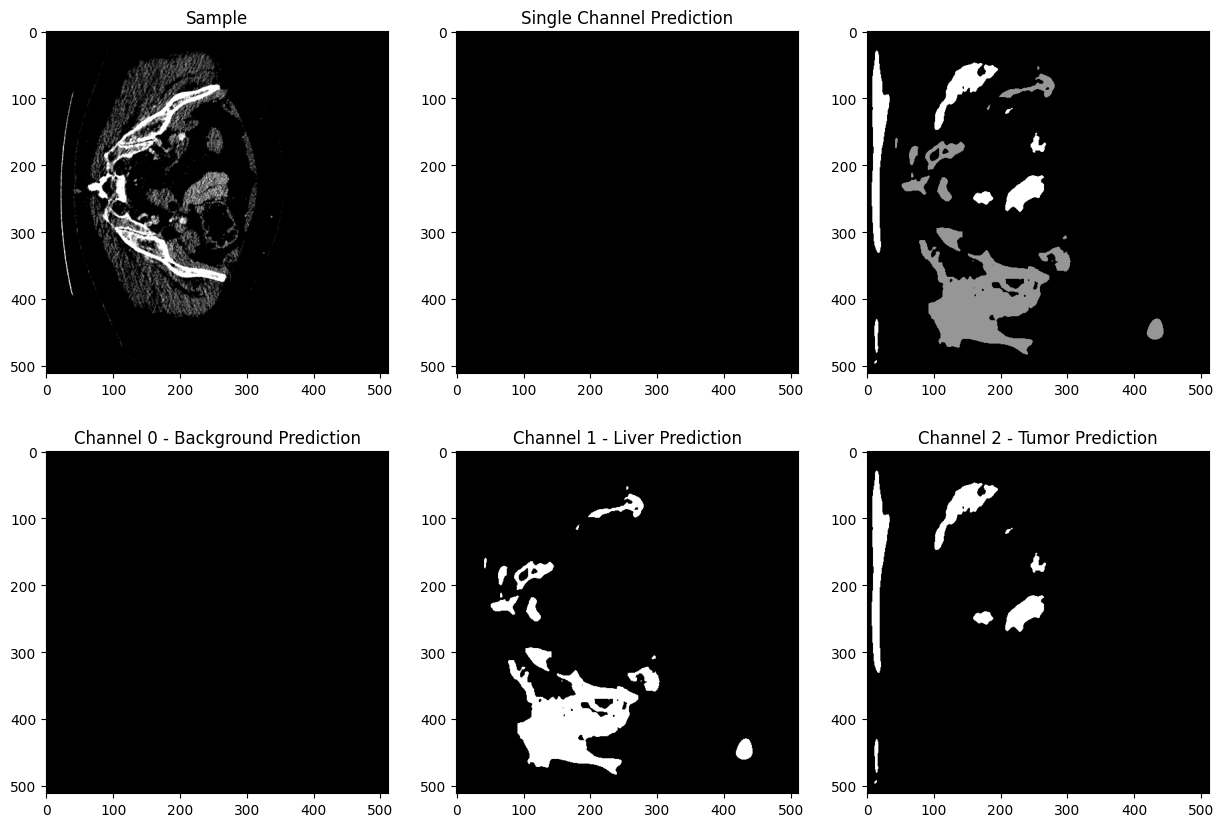

In [81]:
samples_batch, annotations_batch = next(iter(validation_dataloader))

predictions_logits_batch = model(samples_batch)

logitsToProbabilities = torch.nn.Softmax(dim=1)
predictions_probabilities_batch = logitsToProbabilities(predictions_logits_batch)

print(f"Samples batch of shape {samples_batch.shape} with elements of type {type(samples_batch[0,0,0,0].item())} between {samples_batch.min()} and {samples_batch.max()}")
print(f"Annotations batch of shape {annotations_batch.shape} with elements of type {type(annotations_batch[0,0,0].item())} between {annotations_batch.min()} and {annotations_batch.max()}")
print(f"Predictions(logits) batch of shape {predictions_logits_batch.shape} with elements of type {type(predictions_logits_batch[0,0,0,0].item())} between {predictions_logits_batch.min()} and {predictions_logits_batch.max()}")
print(f"Predictions(probabilities) batch of shape {predictions_probabilities_batch.shape} with elements of type {type(predictions_probabilities_batch[0,0,0,0].item())} between {predictions_probabilities_batch.min()} and {predictions_probabilities_batch.max()}")

predictionConfidenceThreshold = 0.999
multiChannelPredictedMask = predictions_probabilities_batch[0].numpy(force=True)

backgroundPredictionMask = multiChannelPredictedMask[0]
backgroundPredictionMask[backgroundPredictionMask > predictionConfidenceThreshold] = 1
backgroundPredictionMask[backgroundPredictionMask <= predictionConfidenceThreshold] = 0

liverPredictionMask = multiChannelPredictedMask[1]
liverPredictionMask[liverPredictionMask > predictionConfidenceThreshold] = 1
liverPredictionMask[liverPredictionMask <= predictionConfidenceThreshold] = 0

tumorPredictionMask = multiChannelPredictedMask[2]
tumorPredictionMask[tumorPredictionMask > predictionConfidenceThreshold] = 1
tumorPredictionMask[tumorPredictionMask <= predictionConfidenceThreshold] = 0

singleChannelPredictedMask = np.zeros((512, 512), dtype=np.uint8)
singleChannelPredictedMask[backgroundPredictionMask == 1] = 45
singleChannelPredictedMask[liverPredictionMask == 1] = 150
singleChannelPredictedMask[tumorPredictionMask == 1] = 255

# Plot
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

axs[0,0].set_title("Sample")
axs[0,0].imshow(samples_batch[0,0].cpu(), cmap="gray")

axs[0,1].set_title("Annotation")
axs[0,1].imshow(annotations_batch[0].cpu(), cmap="gray")

axs[0,1].set_title("Single Channel Prediction")
axs[0,2].imshow(singleChannelPredictedMask, cmap="gray")

axs[1,0].set_title("Channel 0 - Background Prediction")
axs[1,0].imshow(multiChannelPredictedMask[0], cmap="gray")

axs[1,1].set_title("Channel 1 - Liver Prediction")
axs[1,1].imshow(multiChannelPredictedMask[1], cmap="gray")

axs[1,2].set_title("Channel 2 - Tumor Prediction")
axs[1,2].imshow(multiChannelPredictedMask[2], cmap="gray")